In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Bidirectional
# You may need to import other relevant libraries like for data loading, preprocessing, training, etc.


2025-03-30 03:07:51.194218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 03:07:51.242547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743318471.267863   50736 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743318471.276391   50736 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 03:07:51.319660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Cell 2: Define the load_data function
def load_data(train_path, val_path, test_path):
    """Load all datasets from text files"""
    try:
        # Load datasets
        train_df = pd.read_csv(train_path, sep=';', encoding='utf-8')
        val_df = pd.read_csv(val_path, sep=';', encoding='utf-8')
        test_df = pd.read_csv(test_path, sep=';', encoding='utf-8')
        
        # Verify required columns
        for df, name in [(train_df, 'train'), (val_df, 'val'), (test_df, 'test')]:
            if 'Text' not in df.columns or 'Emotions' not in df.columns:
                raise ValueError(f"{name} dataset must contain 'Text' and 'Emotions' columns")
        
        return train_df, val_df, test_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

In [3]:
# Cell 3: Define the preprocess_data function
def preprocess_data(train_df, val_df, test_df, max_words=10000, max_len=100):
    """Preprocess text data and prepare for model"""
    # Combine all text for tokenizer fitting
    all_text = pd.concat([train_df['Text'], val_df['Text'], test_df['Text']])
    
    # Tokenize text
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(all_text)
    
    # Convert texts to sequences
    X_train = tokenizer.texts_to_sequences(train_df['Text'])
    X_val = tokenizer.texts_to_sequences(val_df['Text'])
    X_test = tokenizer.texts_to_sequences(test_df['Text'])
    
    # Pad sequences
    X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
    X_val = pad_sequences(X_val, maxlen=max_len, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_df['Emotions'])
    y_val = label_encoder.transform(val_df['Emotions'])
    y_test = label_encoder.transform(test_df['Emotions'])
    
    # Convert to categorical for multi-class classification
    num_classes = len(label_encoder.classes_)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, tokenizer, label_encoder, num_classes

In [4]:
# Cell 4: Define the build_model function
def build_model(num_classes, max_words=10000, embedding_dim=128, lstm_units=64):
    """Build LSTM model for text classification"""
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=100),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(lstm_units)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [5]:
# Cell 5: Define the train_model function
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=128):
    """Train the model with callbacks"""
    callbacks = [
        EarlyStopping(patience=2, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [6]:
# Cell 6: Define the evaluate_model function
def evaluate_model(model, X_test, y_test, label_encoder):
    """Evaluate model on test set"""
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Classification report
    print("\nTest Set Performance:")
    print(classification_report(
        y_true_classes, 
        y_pred_classes, 
        target_names=label_encoder.classes_
    ))
    
    # Sample predictions
    print("\nSample Predictions:")
    for i in range(min(5, len(X_test))):
        true_label = label_encoder.inverse_transform([y_true_classes[i]])[0]
        pred_label = label_encoder.inverse_transform([y_pred_classes[i]])[0]
        print(f"True: {true_label} | Predicted: {pred_label}")

In [7]:
# Cell 7: Define the plot_history function
def plot_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Dataset Statistics:
Training samples: 16000
Validation samples: 2000
Test samples: 2000

Emotion distribution in training set:
Emotions
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

Number of classes: 6
Vocabulary size: 17097


/home/somya/tensorflow_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/10
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3246 - loss: 1.6085

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3255 - loss: 1.6070 - val_accuracy: 0.5065 - val_loss: 1.2428
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6885 - loss: 0.8532

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6890 - loss: 0.8520 - val_accuracy: 0.8250 - val_loss: 0.5284
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8845 - loss: 0.3514

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8845 - loss: 0.3511 - val_accuracy: 0.8720 - val_loss: 0.3856
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9342 - loss: 0.1924

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9343 - loss: 0.1924 - val_accuracy: 0.9060 - val_loss: 0.3273
Epoch 5/10
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9599 - loss: 0.1301

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9599 - loss: 0.1302 - val_accuracy: 0.9185 - val_loss: 0.3177
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9678 - loss: 0.1028 - val_accuracy: 0.9005 - val_loss: 0.3353
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9793 - loss: 0.0699 - val_accuracy: 0.9040 - val_loss: 0.3665
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Test Set Performance:
              precision    recall  f1-score   support

       anger       0.95      0.84      0.89       275
        fear       0.85      0.89      0.87       224
         joy       0.92      0.91      0.92       695
        love       0.68      0.83      0.75       159
     sadness       0.95      0.95      0.95       581
    surprise       0.70      0.64      0.67        66

    accuracy                           0.90      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.90      0.90      0.90      2000


Sample Prediction

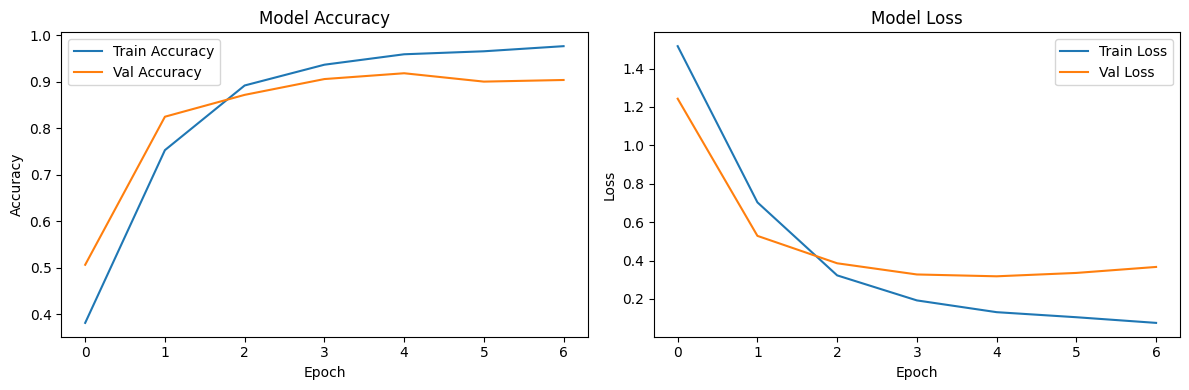


Model, tokenizer, label encoder, weights, and architecture saved successfully.


In [10]:
# Cell 8.1: Define the main function (data loading, preprocessing, model building, training)
def main():
    # File paths
    train_file = 'train.txt'
    val_file = 'val.txt'
    test_file = 'test.txt'
    
    # Load data
    train_df, val_df, test_df = load_data(train_file, val_file, test_file)
    if train_df is None or val_df is None or test_df is None:
        return
    
    # Data statistics
    print("Dataset Statistics:")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    
    print("\nEmotion distribution in training set:")
    print(train_df['Emotions'].value_counts())
    
    # Preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test, tokenizer, label_encoder, num_classes = preprocess_data(
        train_df, val_df, test_df
    )
    
    print(f"\nNumber of classes: {num_classes}")
    print(f"Vocabulary size: {len(tokenizer.word_index)}")
    
    # Build model
    model = build_model(num_classes)
    model.summary()
    
    # Train model
    print("\nTraining model...")
    history = train_model(model, X_train, y_train, X_val, y_val)
    
    # Evaluate model
    evaluate_model(model, X_test, y_test, label_encoder)
    
    # Plot training history
    plot_history(history)
    
    # Save the full model
    model.save('emotion_classifier.h5')
    
    # Call the save_model_artifacts function
    save_model_artifacts(model, tokenizer, label_encoder)

# Cell 8.2: Define the save_model_artifacts function (weights, architecture, tokenizer, label encoder)
def save_model_artifacts(model, tokenizer, label_encoder):
    # Save model weights and architecture
    weights = model.get_weights()
    architecture = []
    
    for layer in model.layers:
        if isinstance(layer, Embedding):
            architecture.append(("Embedding", layer.input_dim, layer.output_dim))  
        elif isinstance(layer, Bidirectional):
            lstm_layer = layer.forward_layer  # Access forward LSTM layer
            architecture.append(("Bidirectional_LSTM", lstm_layer.units * 2))  
        elif isinstance(layer, LSTM):
            architecture.append(("LSTM", layer.units))
        elif isinstance(layer, Dense):
            architecture.append(("Dense", layer.units, layer.activation.__name__))
        elif isinstance(layer, Dropout):
            architecture.append(("Dropout", layer.rate))  # Store dropout rate
        else:
            architecture.append((layer.__class__.__name__, layer.get_output_shape_at(0)))  

    # Save weights and architecture
    with open('model_weights.pickle', 'wb') as f:
        pickle.dump(weights, f)
    with open('model_architecture.pickle', 'wb') as f:
        pickle.dump(architecture, f)

    # Save tokenizer and label encoder
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('label_encoder.pickle', 'wb') as handle:
        pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("\nModel, tokenizer, label encoder, weights, and architecture saved successfully.")


# Cell 8.3: Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
import tensorflow as tf
import pickle
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model
model = tf.keras.models.load_model('emotion_classifier.h5')

# Load tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load label encoder
with open('label_encoder.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

def predict_text(text, model, tokenizer, label_encoder, max_len=100):
    """Predict the emotion of a given text input."""
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(padded_sequence)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    # Convert class index back to label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label

# Run prediction in a loop for user input
while True:
    user_text = input("Enter a sentence (or type 'exit' to quit): ")
    
    if user_text.lower() == 'exit':
        print("Goodbye!")
        break
    
    predicted_emotion = predict_text(user_text, model, tokenizer, label_encoder)
    print(f"Predicted Emotion: {predicted_emotion}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
Predicted Emotion: fear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Emotion: fear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Emotion: fear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Emotion: joy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Emotion: sadness

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Emotion: fear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Emotion: fear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Emotion: fear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Emotion: fear

